# Final Project

## Data Description
### players.csv
- Number of observations: 196
- Number of variables: 9
| Variable   | Description                | Data Type | Example Value   |
|------------|----------------------------|-----------|-----------------|
| `experience` | Player's experience level (e.g. Beginner, Amateur, etc.)      | Categorical (factor)    | `Pro`    |
| `subscribe`      | Whether player has subscribed to PlaiCraft's email updates    | logical   | `TRUE`            |
| `hashedEmail` | Unique hashed email identifier for player | character   | `f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d`          |
| `played_hours`  | Total play time in hours     | double     | `30.3`       |
| `name`| Player's name | character  | `Morgan` |
| `gender`| Player's gender (e.g. Male, Female, etc.) | Categorical (factor)  | `Male` |
| `age`| Player's age in years | integer  | `9` |
| `individualId`| No values provided | N/A  | `NA` |
| `organizationName`| No values provided | N/A  | `NA` |

### sessions.csv
- Number of observations: 1,535
- Number of variables: 5
| Variable   | Description                | Data Type | Example Value   |
|------------|----------------------------|-----------|-----------------|
| `hashedEmail` | Unique hashed email identifier for player | character   | `bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf`          |
| `start_time`      | Start timestamp of the play session (DD/MM/YYYY HH:MM)    | date-time (dttm)   | `30/06/2024 18:12`            |
| `end_time` | End timestamp of the play session (DD/MM/YYYY HH:MM) | date-time (dttm)   | `30/06/2024 18:24`          |
| `original_start_time`  | Scheduled start time in UNIX timestamp format     | double     | `1.71977E+12`       |
| `original_end_time`| Scheduled end time in UNIX timestamp format | double  | `1.71977E+12` |

### Potential Issues
- `individualId` and `organizationName` have no values; `end_time` and `original_end_time` have missing values
- Need to check if all `hashedEmail` values match across the CSV files; only the matches will have data from both CSV files
- Must verify that all timestamps are correct i.e. end times come after start times and the DD/MM/YYYY HH:MM values match the UNIX timestamp values
- Not enough digits in `original_start_time` and `original_end_time` to see any difference between them

## Introduction
Background: A group in Computer Science at UBC is interested in understanding how people play video games. They have set up a server running MineCraft and are recording play sessions. The server is called PlaiCraft.

We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability.

Our project focuses on the second question: What time windows are most likely to have large number of simultaneous players? This insight is critical for demand forecasting to ensure that we maintain a sufficient number of licenses to accommodate all players concurrently with a high probability. 

Our analysis will involve the number of simultaneous players at a given time (response variable), session start and end times (explanatory variables).

Specific Question: Can `time_of_day`, `day_of_week`, `month`, `experience`, and `session_duration` accurately predict the number of simultaneous players (`player_count`) over a 1-hour time window using K-NN regression?

We will calculate `time_of_day`, `day_of_week`, `month`, `session_duration` from `start_time` and `end_time`, and `player_count` using 1-hour time windows over the time range in the data.

Note: we are not using `age`, `subscribe`, or `gender` because they are unreliable - many participants lie about their age and gender and subscribe is unlikely to be indicative of play time.

## Exploratory Data Analysis and Visualization

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# show dataset can be loaded into R
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

players <- read_csv(players_url)
sessions <- read_csv(sessions_url)

# players
# sessions

# get names of columns with missing/NA values (for data description)
players_na_cols <- players |>
    select_if(~ any(is.na(.))) |>
    names()
players_na_cols

sessions_na_cols <- sessions |>
    select_if(~ any(is.na(.))) |>
    names()
sessions_na_cols

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "individualId"     "organizationName"

[1] "end_time"          "original_end_time"

In [3]:
# individualId and organizationName not needed b/c they are empty
# data is already tidy - each row is a single observation (unique player), each column is a single variable, each value is a single cell
players_tidy <- select(players, -individualId, -organizationName)
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [4]:
# digits given in original_start_time and original_end_time are not specific enough to get any difference between the 2 columns, can remove
# data is already tidy - each row is a single observation (play session), each column is a single variable, each value is a single cell
sessions_tidy <- sessions |>
    select(-original_start_time, -original_end_time) |>
    mutate(
        start_time = dmy_hm(start_time), # convert to POSIXct using lubridate::dmy_hm()
        end_time = dmy_hm(end_time)
        )
head(sessions_tidy)

hashedEmail,start_time,end_time
<chr>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


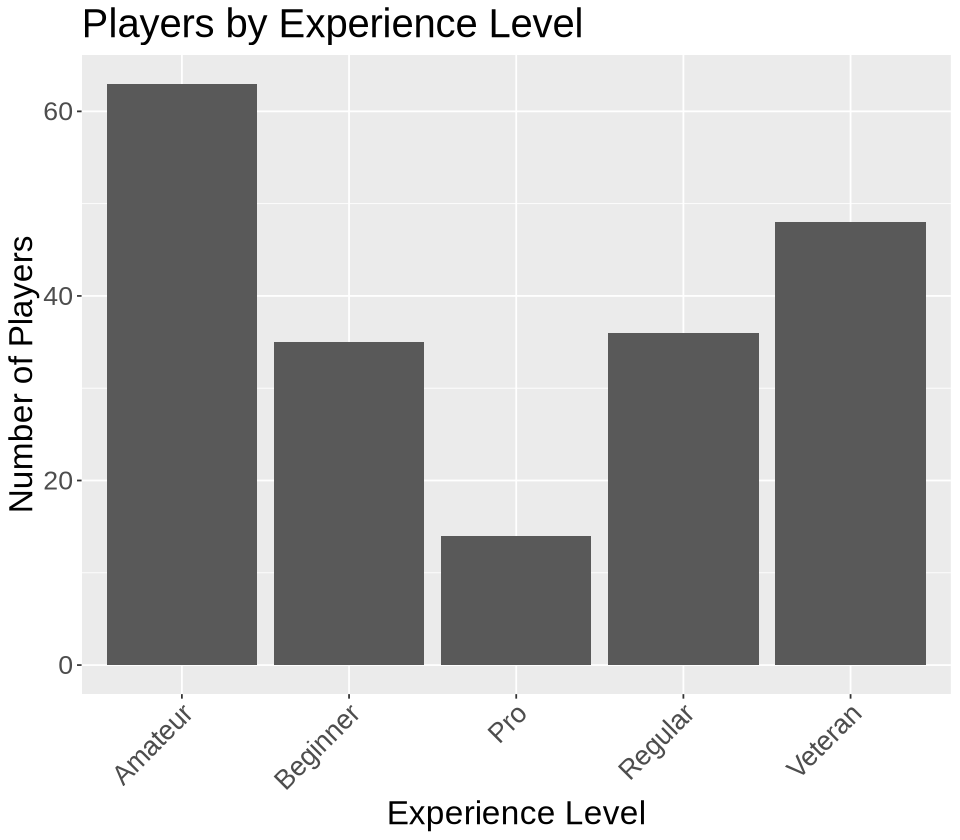

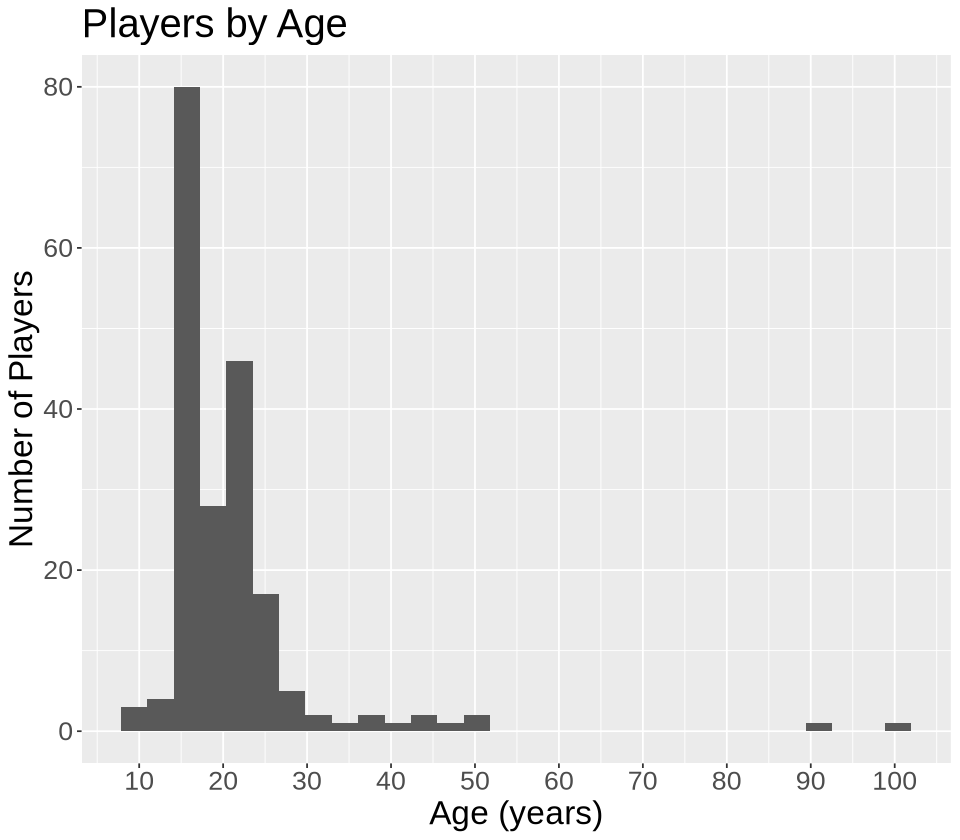

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_summary()`).”


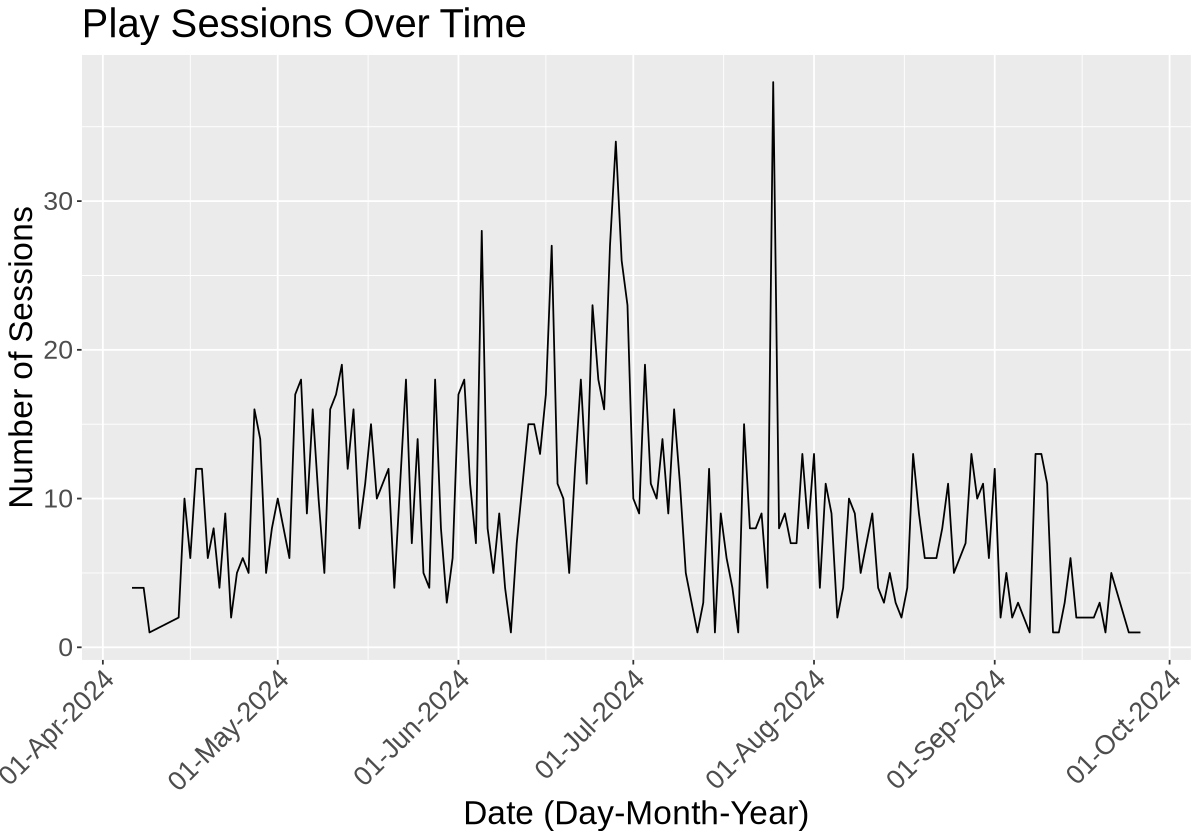

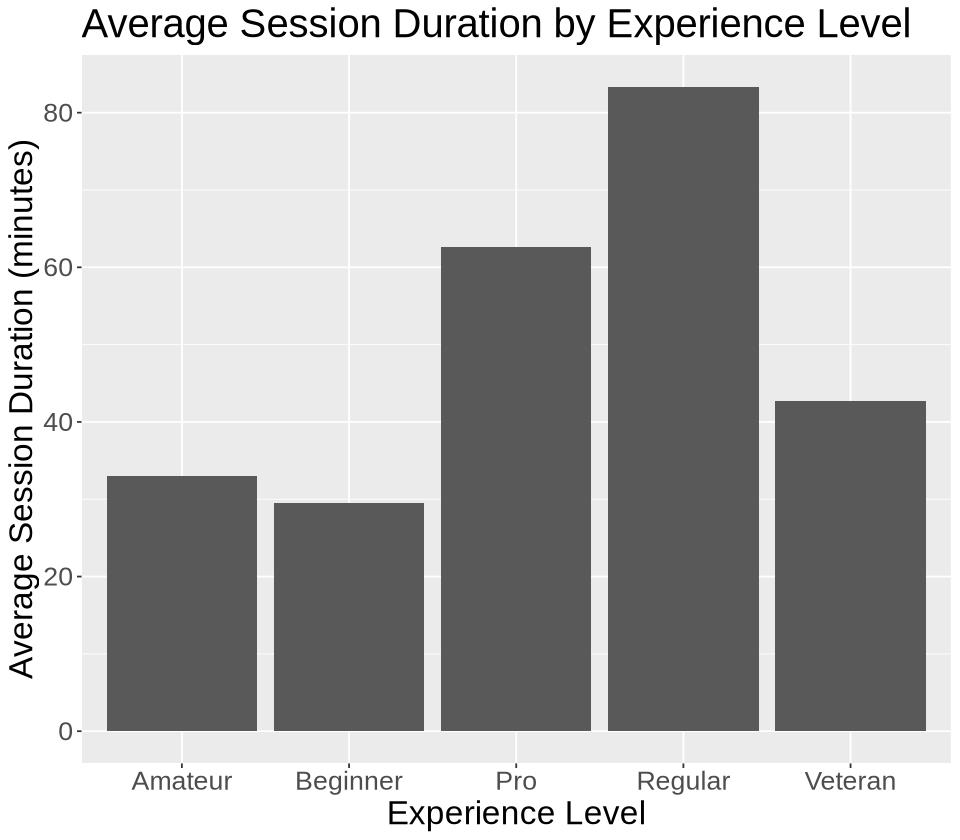

In [5]:
# Visualizations
# Distribution of players by experience level plot
options(repr.plot.width = 8, repr.plot.height = 7)
players_by_exp_plot <- ggplot(players_tidy, aes(x = experience)) +
  geom_bar() +
  labs(
    title = "Players by Experience Level",
    x = "Experience Level",
    y = "Number of Players"
  ) +
  theme(
      text = element_text(size = 20),
      axis.text.x = element_text(angle = 45, hjust = 1)
  )
players_by_exp_plot

# Distribution of players by age plot
# Default with 30 bins looks good
players_by_age_plot <- ggplot(players_tidy, aes(x = age)) +
  geom_histogram() +
  labs(
    title = "Players by Age",
    x = "Age (years)",
    y = "Number of Players"
  ) +
    scale_x_continuous(
    breaks = seq(0, 100, by = 10)  # set breaks at every 10 years
    ) +
  theme(text = element_text(size = 20))
players_by_age_plot

# Sessions over time plot
options(repr.plot.width = 10, repr.plot.height = 7)
session_counts <- sessions_tidy |>
    mutate(start_date = as.Date(start_time)) |>
    group_by(start_date) |>
    summarise(session_count = n())

sessions_time_plot <- ggplot(session_counts, aes(x = start_date, y = session_count)) +
  geom_line() +
  labs(
    title = "Play Sessions Over Time",
    x = "Date (Day-Month-Year)",
    y = "Number of Sessions"
  ) +
  theme(
      text = element_text(size = 20),
       axis.text.x = element_text(angle = 45, hjust = 1)
       ) +
  scale_x_date(
    date_labels = "%d-%b-%Y",  # Day-Month-Year format
    date_breaks = "1 month"     # breaks every month
  )
sessions_time_plot

# Average session duration by experience level plot
# left join using hashedEmail
sessions_players_joined <- left_join(sessions_tidy, players_tidy, by = "hashedEmail") |>
  mutate(
    session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
  )

options(repr.plot.width = 8, repr.plot.height = 7)
avg_session_exp_plot <- ggplot(sessions_players_joined, aes(x = experience, y = session_duration)) +
  geom_bar(stat = "summary", fun = "mean") +  # mean session duration
  labs(title = "Average Session Duration by Experience Level",
       x = "Experience Level",
       y = "Average Session Duration (minutes)") +
  theme(text = element_text(size = 20))
avg_session_exp_plot

In [6]:

merged_data <- sessions_tidy |>
  inner_join(players_tidy, by = "hashedEmail") |>
  mutate(
    session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
  )


head(merged_data)


hashedEmail,start_time,end_time,experience,subscribe,played_hours,name,gender,age,session_duration
<chr>,<dttm>,<dttm>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,Regular,TRUE,223.1,Hiroshi,Male,17,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,Amateur,TRUE,53.9,Alex,Male,17,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,Amateur,TRUE,150.0,Delara,Female,16,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,Regular,TRUE,223.1,Hiroshi,Male,17,36
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,Amateur,TRUE,53.9,Alex,Male,17,11
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,Regular,TRUE,223.1,Hiroshi,Male,17,122


Columns in sessions_tidy:
[1] "hashedEmail" "start_time"  "end_time"   
Columns in players_tidy:
[1] "experience"   "subscribe"    "hashedEmail"  "played_hours" "name"        
[6] "gender"       "age"         


 hashedEmail          start_time                    
 Length:1535        Min.   :2024-04-06 09:27:00.00  
 Class :character   1st Qu.:2024-05-20 20:28:00.00  
 Mode  :character   Median :2024-06-24 02:51:00.00  
                    Mean   :2024-06-24 03:54:03.51  
                    3rd Qu.:2024-07-25 06:56:00.00  
                    Max.   :2024-09-26 06:09:00.00  
                                                    
    end_time                       experience        subscribe      
 Min.   :2024-04-06 09:31:00.00   Length:1535        Mode :logical  
 1st Qu.:2024-05-20 21:37:00.00   Class :character   FALSE:103      
 Median :2024-06-23 22:04:00.00   Mode  :character   TRUE :1432     
 Mean   :2024-06-24 02:26:18.03                                     
 3rd Qu.:2024-07-25 07:00:00.00                                     
 Max.   :2024-09-26 07:39:00.00                                     
 NA's   :2                                                          
  played_hours        na

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


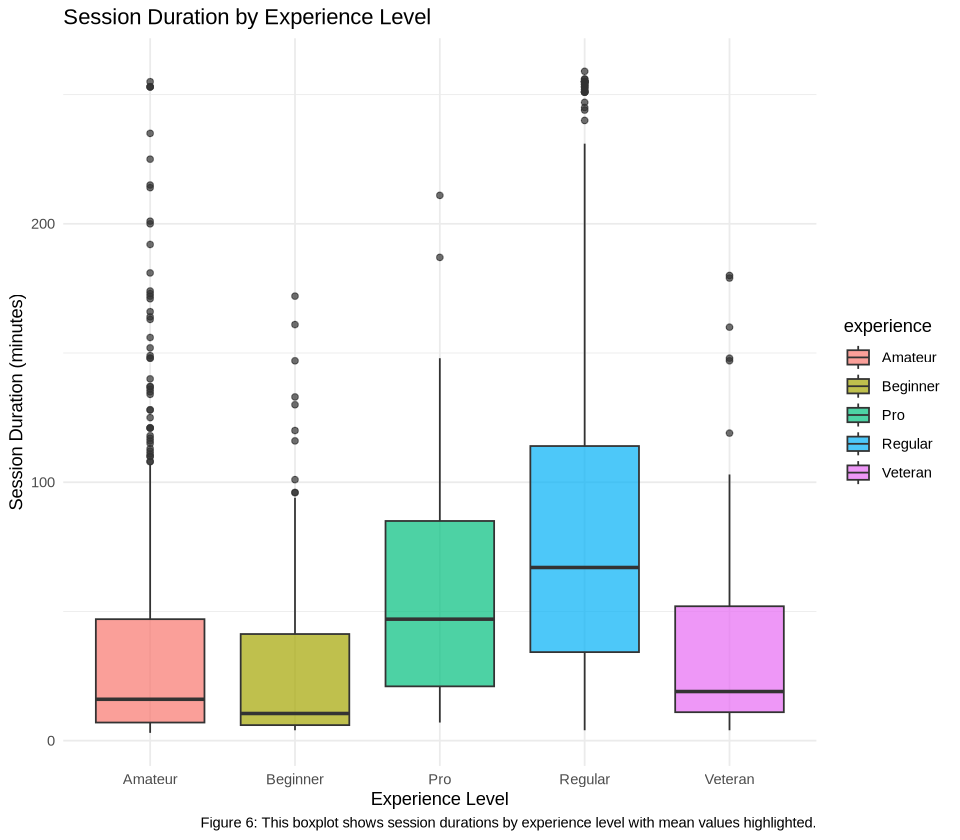

In [7]:

cat("Columns in sessions_tidy:\n")
print(colnames(sessions_tidy))


cat("Columns in players_tidy:\n")
print(colnames(players_tidy))


summary(merged_data)

ggplot(merged_data, aes(x = experience, y = session_duration, fill = experience)) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Session Duration by Experience Level",
    x = "Experience Level",
    y = "Session Duration (minutes)",
       caption = "Figure 6: This boxplot shows session durations by experience level with mean values highlighted."
  ) +
  theme_minimal()


### Relevant Insights
- Players by Age histogram shows a skewed distribution with most players between ages 10 and 25, suggesting the relationship between age and other variables may not be linear
- Play Time vs Age scatter plot has most points clustered near the bottom with some outliers spread out, appears non-linear, high variation in play time
- Play Sessions Over Time line plot oscillates wildly, appears non-linear
- Significant outliers are present in all experience levels, especially among Regular players.

In [9]:
# left join using hashedEmail
sessions_players_joined <- left_join(sessions_tidy, players_tidy, by = "hashedEmail") |>
  mutate(
    session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
  ) |>
    filter(!is.na(end_time)) # filter out any rows with NA values

head(sessions_players_joined)

time_windows <- data.frame(
  time_window = seq(from = floor_date(min(sessions_players_joined$start_time), "hour"), 
                    to = ceiling_date(max(sessions_players_joined$end_time), "hour"), 
                    by = "hour")
)
head(time_windows)

# perform a cross join between sessions and time windows
player_counts <- time_windows |>
  # use expand_grid to generate all combinations of time_window and sessions
  expand_grid(session = sessions_players_joined) |>
  # filter for sessions that overlap with the time window
  filter(session$start_time < time_window + hours(1) & session$end_time > time_window) |>
  # group by time_window to get player count, most frequent experience level, and total session duration
  group_by(time_window) |>
  summarise(
    player_count = n(),  # count number of sessions overlapping the time window
    most_frequent_experience = names(sort(table(session$experience), decreasing = TRUE))[1],  # Most frequent experience level
    total_session_duration = sum(session$session_duration, na.rm = TRUE),  # Sum of session durations
    .groups = "drop"
  ) |>
    mutate(
    month = month(time_window, label = TRUE),      # month (Jan, Feb, ..., Dec)
    day_of_week = wday(time_window, label = TRUE),  # day of the week (Mon, Tue, ..., Sun)
    hour = hour(time_window)                      # hour (0-23)
  )

head(player_counts)

# one-hot encoding the categorical variables
player_counts_encoded <- player_counts |>
  mutate(
    most_frequent_experience = as.factor(most_frequent_experience),  # convert to factor for one-hot encoding
    month = as.factor(month),
    day_of_week = as.factor(day_of_week)
  ) |>
  # one-hot encode using model.matrix
  bind_cols(
    model.matrix(~ most_frequent_experience - 1, data = player_counts)[, -1],  # remove intercept column, one-hot encode most_frequent_experience
    model.matrix(~ month - 1, data = player_counts)[, -1],  # one-hot encode month
    model.matrix(~ day_of_week - 1, data = player_counts)[, -1]  # one-hot encode day_of_week
  )

head(player_counts_encoded)

hashedEmail,start_time,end_time,experience,subscribe,played_hours,name,gender,age,session_duration
<chr>,<dttm>,<dttm>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,Regular,TRUE,223.1,Hiroshi,Male,17,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,Amateur,TRUE,53.9,Alex,Male,17,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,Amateur,TRUE,150.0,Delara,Female,16,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,Regular,TRUE,223.1,Hiroshi,Male,17,36
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,Amateur,TRUE,53.9,Alex,Male,17,11
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,Regular,TRUE,223.1,Hiroshi,Male,17,122


,time_window
,<dttm>
1,2024-04-06 09:00:00
2,2024-04-06 10:00:00
3,2024-04-06 11:00:00
4,2024-04-06 12:00:00
5,2024-04-06 13:00:00
6,2024-04-06 14:00:00


time_window,player_count,most_frequent_experience,total_session_duration,month,day_of_week,hour
<dttm>,<int>,<chr>,<dbl>,<ord>,<ord>,<int>
2024-04-06 09:00:00,2,Amateur,45,Apr,Sat,9
2024-04-06 10:00:00,1,Amateur,41,Apr,Sat,10
2024-04-06 20:00:00,1,Amateur,68,Apr,Sat,20
2024-04-06 21:00:00,1,Amateur,68,Apr,Sat,21
2024-04-06 22:00:00,2,Amateur,137,Apr,Sat,22
2024-04-06 23:00:00,1,Pro,69,Apr,Sat,23


time_window,player_count,most_frequent_experience,total_session_duration,month,day_of_week,hour,most_frequent_experienceBeginner,most_frequent_experiencePro,most_frequent_experienceRegular,⋯,monthSep,monthOct,monthNov,monthDec,day_of_weekMon,day_of_weekTue,day_of_weekWed,day_of_weekThu,day_of_weekFri,day_of_weekSat
<dttm>,<int>,<fct>,<dbl>,<ord>,<ord>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-04-06 09:00:00,2,Amateur,45,Apr,Sat,9,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 10:00:00,1,Amateur,41,Apr,Sat,10,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 20:00:00,1,Amateur,68,Apr,Sat,20,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 21:00:00,1,Amateur,68,Apr,Sat,21,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 22:00:00,2,Amateur,137,Apr,Sat,22,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 23:00:00,1,Pro,69,Apr,Sat,23,0,1,0,⋯,0,0,0,0,0,0,0,0,0,1


In [13]:
summary(sessions_tidy$start_time)
summary(sessions_tidy$end_time)


                      Min.                    1st Qu. 
"2024-04-06 09:27:00.0000" "2024-05-20 20:26:00.0000" 
                    Median                       Mean 
"2024-06-23 21:56:00.0000" "2024-06-24 02:02:39.7911" 
                   3rd Qu.                       Max. 
"2024-07-25 06:55:15.0000" "2024-09-26 06:09:00.0000" 
                      NA's 
                       "3" 

                      Min.                    1st Qu. 
"2024-04-06 09:31:00.0000" "2024-05-20 21:37:00.0000" 
                    Median                       Mean 
"2024-06-23 22:04:00.0000" "2024-06-24 02:41:45.1275" 
                   3rd Qu.                       Max. 
"2024-07-25 07:00:00.0000" "2024-09-26 07:39:00.0000" 
                      NA's 
                       "6" 

In [63]:
library(tidymodels)


# Recipe with one-hot encoding for day_of_week
recipe <- recipe(simultaneous_players ~ hour_of_day + day_of_week, data = train_data) |>
  step_dummy(all_nominal_predictors(), -all_outcomes()) |>
  step_normalize(all_numeric_predictors()) 

# Preview the recipe
prep_recipe <- prep(recipe, training = train_data)
bake(prep_recipe, new_data = NULL) 

library(tidymodels)

# Define a recipe for one-hot encoding and normalization
recipe <- recipe(simultaneous_players ~ hour_of_day + day_of_week, data = your_data) |>
  step_dummy(all_nominal_predictors(), -all_outcomes()) |>  # One-hot encode categorical predictors
  step_normalize(all_numeric_predictors())                 # Normalize numeric predictors

# Prep and bake the recipe to inspect the transformed data
prep_recipe <- prep(recipe, training = your_data)
encoded_data <- bake(prep_recipe, new_data = NULL)

# View the transformed data
head(encoded_data)




hour_of_day,simultaneous_players,day_of_week_Mon,day_of_week_Tue,day_of_week_Wed,day_of_week_Thu,day_of_week_Fri,day_of_week_Sat
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.66926668,0,-0.4084736,-0.4049549,2.4474016,-0.4054584,-0.4074696,-0.4114793
1.66926668,0,-0.4084736,-0.4049549,-0.4084736,-0.4054584,2.4534320,-0.4114793
-1.23232430,5,2.4474016,-0.4049549,-0.4084736,-0.4054584,-0.4074696,-0.4114793
-0.79708565,1,-0.4084736,-0.4049549,-0.4084736,-0.4054584,-0.4074696,-0.4114793
0.94386894,0,-0.4084736,-0.4049549,-0.4084736,2.4656018,-0.4074696,-0.4114793
-1.37740385,4,-0.4084736,-0.4049549,-0.4084736,-0.4054584,-0.4074696,2.4295242
1.52418713,0,-0.4084736,-0.4049549,-0.4084736,2.4656018,-0.4074696,-0.4114793
1.08894848,0,-0.4084736,-0.4049549,-0.4084736,-0.4054584,-0.4074696,2.4295242
1.52418713,0,-0.4084736,2.4686673,-0.4084736,-0.4054584,-0.4074696,-0.4114793


ERROR: Error in eval(expr, envir, enclos): object 'your_data' not found


In [64]:
# Set up the recipe with one-hot encoding
recipe <- recipe(simultaneous_players ~ hour_of_day + day_of_week, data = train_data) |>
  step_dummy(all_nominal_predictors(), -all_outcomes()) |>
  step_normalize(all_numeric_predictors())

# Define the KNN model
knn_model <- nearest_neighbor(neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("regression")

# Define the workflow
workflow <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_model)

# Train the model
fit <- workflow |>
  fit(data = train_data)

# Evaluate on test data
results <- fit |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = simultaneous_players, estimate = .pred)

print(results)

# A tibble: 3 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard      1.14  
2 rsq     standard      0.0610
3 mae     standard      0.725 


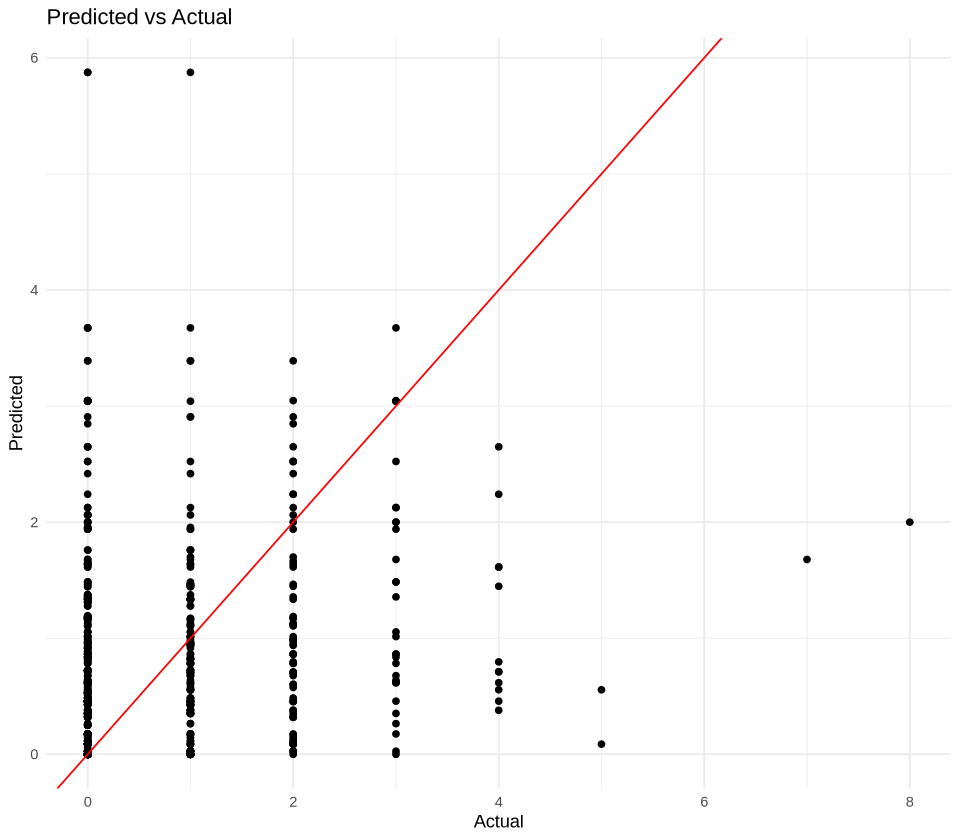

In [65]:
ggplot(bind_cols(test_data, pred = predict(fit, test_data)$.pred), aes(x = simultaneous_players, y = pred)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, color = "red") +
  labs(title = "Predicted vs Actual", x = "Actual", y = "Predicted") +
  theme_minimal()


In [66]:
player_counts_encoded <- player_counts |>
  mutate(
    # Map months to numeric values (Jan=1, Feb=2, ..., Dec=12)
    month = recode(month,
                        Jan = 1,
                        Feb = 2,
                        Mar = 3,
                        Apr = 4,
                        May = 5,
                        Jun = 6,
                        Jul = 7,
                        Aug = 8,
                        Sep = 9,
                        Oct = 10,
                        Nov = 11,
                        Dec = 12),
    
    # Map days of the week to numeric values (Mon=1, Tue=2, ..., Sun=7)
    day_of_week = as.numeric(factor(day_of_week, levels = c("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"))),
    
    # Map experience levels to numeric values (Beginner=1, Amateur=2, Regular=3, Pro=4, Veteran=5)
    most_frequent_experience = as.numeric(factor(most_frequent_experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")))
  ) |> select(-time_window) 
# |> # exclude original categorical columns and time_window from predictors
#     select(where(~ any(. != 0))) |> # remove any zero only columns
#     select(where(~ sd(.) > 0))   # remove columns with zero variance
head(player_counts_encoded)

player_count,most_frequent_experience,total_session_duration,month,day_of_week,hour
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2,2,45,4,6,9
1,2,41,4,6,10
1,2,68,4,6,20
1,2,68,4,6,21
2,2,137,4,6,22
1,4,69,4,6,23


In [68]:
missing_rows <- sessions_tidy |>
  filter(is.na(start_time) | is.na(end_time))
print(missing_rows)



# A tibble: 0 × 3
# ℹ 3 variables: hashedEmail <chr>, start_time <dttm>, end_time <dttm>


In [69]:
sessions_tidy <- sessions_tidy |>
  filter(!is.na(start_time) & !is.na(end_time))

In [70]:
summary(sessions_tidy$start_time)
summary(sessions_tidy$end_time)


                      Min.                    1st Qu. 
"2024-04-06 09:27:00.0000" "2024-05-20 20:22:00.0000" 
                    Median                       Mean 
"2024-06-23 21:41:30.0000" "2024-06-23 23:58:52.0969" 
                   3rd Qu.                       Max. 
"2024-07-25 06:46:00.0000" "2024-09-26 06:09:00.0000" 

                      Min.                    1st Qu. 
"2024-04-06 09:31:00.0000" "2024-05-20 21:28:45.0000" 
                    Median                       Mean 
"2024-06-23 21:51:30.0000" "2024-06-24 00:49:35.1507" 
                   3rd Qu.                       Max. 
"2024-07-25 06:50:45.0000" "2024-09-26 07:39:00.0000" 

In [88]:
# Example: Day of week as an ordered factor
day_of_week <- factor(c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", 
                        "Saturday", "Sunday"), 
                      levels = c("Monday", "Tuesday", "Wednesday", "Thursday", 
                                 "Friday", "Saturday", "Sunday"), 
                      ordered = TRUE)

# Convert to numeric
day_of_week_numeric <- as.numeric(day_of_week)

# A tibble: 4,152 × 2
   time_window         simultaneous_players
   <dttm>                             <int>
 1 2024-04-06 09:00:00                    2
 2 2024-04-06 10:00:00                    1
 3 2024-04-06 11:00:00                    0
 4 2024-04-06 12:00:00                    0
 5 2024-04-06 13:00:00                    0
 6 2024-04-06 14:00:00                    0
 7 2024-04-06 15:00:00                    0
 8 2024-04-06 16:00:00                    0
 9 2024-04-06 17:00:00                    0
10 2024-04-06 18:00:00                    0
# ℹ 4,142 more rows


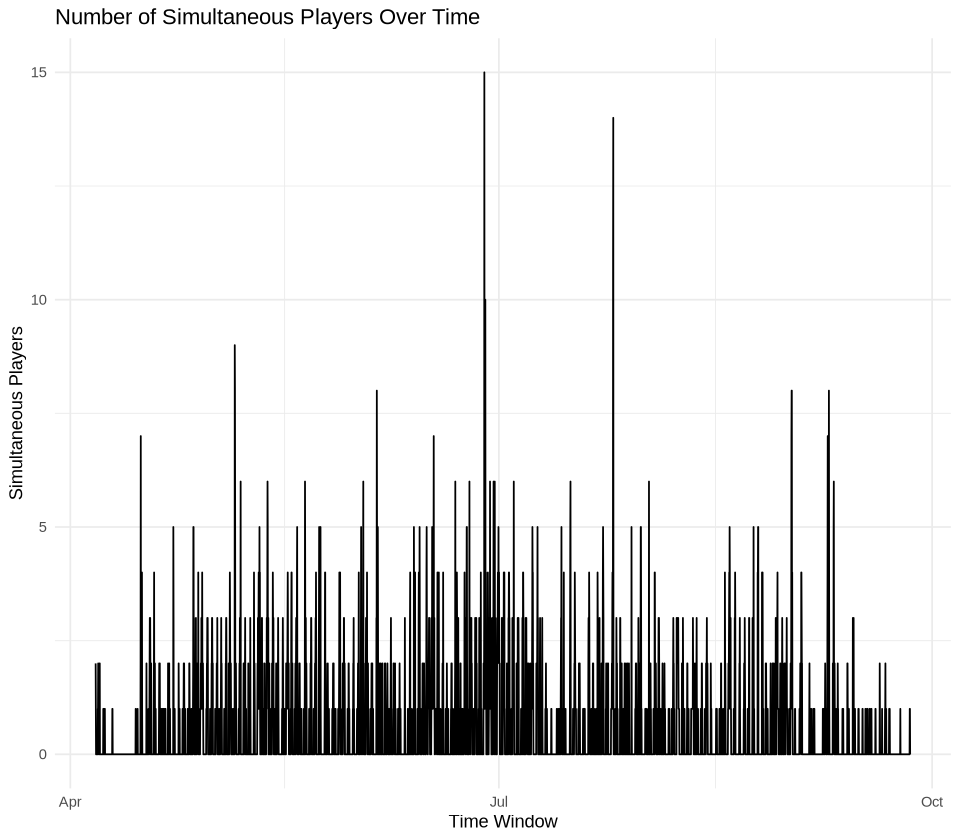

In [89]:
# Generate hourly time windows
time_window <- seq(
  from = floor_date(min(sessions_tidy$start_time), unit = "hour"),
  to = ceiling_date(max(sessions_tidy$end_time), unit = "hour"),
  by = "hour"
)

# Calculate simultaneous players
simultaneous_players <- map_dfr(time_window, function(window_start) {
  window_end <- window_start + hours(1)
  
  # Count players whose sessions overlap with the time window
  count <- sessions_tidy |>
    filter(
      start_time < window_end & end_time > window_start
    ) |>
    nrow()
  
  tibble(
    time_window = window_start,
    simultaneous_players = count
  )
})

# Preview results
print(simultaneous_players)

# Optional: Visualize the results
library(ggplot2)
ggplot(simultaneous_players, aes(x = time_window, y = simultaneous_players)) +
  geom_line() +
  labs(
    title = "Number of Simultaneous Players Over Time",
    x = "Time Window",
    y = "Simultaneous Players"
  ) +
  theme_minimal()


In [90]:

library(lubridate)

# Add explanatory variables
simultaneous_players <- simultaneous_players |>
  mutate(
    hour_of_day = hour(time_window),   
    day_of_week = factor(              
      wday(time_window, label = TRUE),
      ordered = FALSE                 
    )
  )

# Preview data
print(simultaneous_players)



# A tibble: 4,152 × 4
   time_window         simultaneous_players hour_of_day day_of_week
   <dttm>                             <int>       <int> <fct>      
 1 2024-04-06 09:00:00                    2           9 Sat        
 2 2024-04-06 10:00:00                    1          10 Sat        
 3 2024-04-06 11:00:00                    0          11 Sat        
 4 2024-04-06 12:00:00                    0          12 Sat        
 5 2024-04-06 13:00:00                    0          13 Sat        
 6 2024-04-06 14:00:00                    0          14 Sat        
 7 2024-04-06 15:00:00                    0          15 Sat        
 8 2024-04-06 16:00:00                    0          16 Sat        
 9 2024-04-06 17:00:00                    0          17 Sat        
10 2024-04-06 18:00:00                    0          18 Sat        
# ℹ 4,142 more rows


In [93]:
# Libraries
library(tidymodels)

# Set seed for reproducibility
set.seed(123)

# Define initial data split
data_split <- initial_split(simultaneous_players, prop = 0.8)
train_data <- training(data_split)
test_data <- testing(data_split)

# Define response variable
response_variable <- "simultaneous_players"

# Start with no predictors selected
selected_features <- c()
remaining_features <- c("hour_of_day", "day_of_week") # Add other features if applicable

# Initialize results storage
final_results <- list()

# Perform forward selection
for (i in seq_along(remaining_features)) {
  candidate_results <- list()
  
  for (feature in remaining_features) {
    # Current feature set
    current_features <- c(selected_features, feature)
    current_formula <- as.formula(
      paste(response_variable, "~", paste(current_features, collapse = " + "))
    )
    
    # Define the recipe
    recipe <- recipe(current_formula, data = train_data) |>
      step_dummy(all_nominal_predictors(), -all_outcomes()) |>
      step_normalize(all_numeric_predictors())
    
    # Define the KNN model
    knn_model <- nearest_neighbor(neighbors = 6) |> # Use k = 5, modify as needed
      set_engine("kknn") |>
      set_mode("regression")
    
    # Define the workflow
    workflow <- workflow() |>
      add_recipe(recipe) |>
      add_model(knn_model)
    
    # Fit and evaluate the model
    fit <- fit(workflow, data = train_data)
    metrics_result <- fit |>
      predict(test_data) |>
      bind_cols(test_data) |>
      metrics(truth = !!sym(response_variable), estimate = .pred) |>
      filter(.metric == "rmse") |>
      pull(.estimate)
    
    candidate_results[[feature]] <- metrics_result
  }
  
  # Select the best feature based on RMSE
  best_feature <- names(which.min(unlist(candidate_results)))
  selected_features <- c(selected_features, best_feature)
  remaining_features <- setdiff(remaining_features, best_feature)
  
  print(paste("Selected feature:", best_feature))
  print(paste("Current RMSE:", min(unlist(candidate_results))))
  
  # Save results
  final_results[[i]] <- list(
    features = selected_features,
    rmse = min(unlist(candidate_results))
  )
}

# Final model formula
final_formula <- as.formula(paste(response_variable, "~", paste(selected_features, collapse = " + ")))
print(final_formula)


[1] "Selected feature: hour_of_day"
[1] "Current RMSE: 1.06932090418669"
[1] "Selected feature: day_of_week"
[1] "Current RMSE: 1.07067118184525"
simultaneous_players ~ hour_of_day + day_of_week


In [94]:
# Libraries
library(tidymodels)

# Set seed for reproducibility
set.seed(123)

# Prepare data splits
data_split <- initial_split(simultaneous_players, prop = 0.8)
train_data <- training(data_split)
test_data <- testing(data_split)

# Define recipe for "hour_of_day" only
recipe_hour <- recipe(simultaneous_players ~ hour_of_day, data = train_data) |>
  step_normalize(all_numeric_predictors())

# Define recipe for "hour_of_day + day_of_week"
recipe_hour_day <- recipe(simultaneous_players ~ hour_of_day + day_of_week, data = train_data) |>
  step_dummy(all_nominal_predictors(), -all_outcomes()) |>
  step_normalize(all_numeric_predictors())

# Define KNN model
knn_model <- nearest_neighbor(neighbors = 6) |>
  set_engine("kknn") |>
  set_mode("regression")

# Define workflows
workflow_hour <- workflow() |>
  add_recipe(recipe_hour) |>
  add_model(knn_model)

workflow_hour_day <- workflow() |>
  add_recipe(recipe_hour_day) |>
  add_model(knn_model)

# Fit and evaluate the model with "hour_of_day" only
fit_hour <- workflow_hour |>
  fit(data = train_data)

results_hour <- fit_hour |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = simultaneous_players, estimate = .pred)

print("Model with hour_of_day only:")
print(results_hour)

# Fit and evaluate the model with "hour_of_day + day_of_week"
fit_hour_day <- workflow_hour_day |>
  fit(data = train_data)

results_hour_day <- fit_hour_day |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = simultaneous_players, estimate = .pred)

print("Model with hour_of_day + day_of_week:")
print(results_hour_day)

# Compare RMSE
hour_rmse <- results_hour |>
  filter(.metric == "rmse") |>
  pull(.estimate)

hour_day_rmse <- results_hour_day |>
  filter(.metric == "rmse") |>
  pull(.estimate)

print(paste("RMSE for hour_of_day only:", hour_rmse))
print(paste("RMSE for hour_of_day + day_of_week:", hour_day_rmse))

# Decide based on RMSE
if (hour_rmse < hour_day_rmse) {
  print("The model with hour_of_day only performs better.")
} else {
  print("The model with hour_of_day + day_of_week performs better.")
}


[1] "Model with hour_of_day only:"
# A tibble: 3 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard      1.07  
2 rsq     standard      0.0664
3 mae     standard      0.680 
[1] "Model with hour_of_day + day_of_week:"
# A tibble: 3 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard      1.07  
2 rsq     standard      0.0752
3 mae     standard      0.696 
[1] "RMSE for hour_of_day only: 1.06932090418669"
[1] "RMSE for hour_of_day + day_of_week: 1.07067118184525"
[1] "The model with hour_of_day only performs better."


In [80]:
# left join using hashedEmail
sessions_players_joined <- left_join(sessions_tidy, players_tidy, by = "hashedEmail") |>
  mutate(
	session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
  ) |>
	filter(!is.na(end_time)) # filter out any rows with NA values

head(sessions_players_joined)

time_windows <- data.frame(
  time_window = seq(from = floor_date(min(sessions_players_joined$start_time), "hour"),
                	to = ceiling_date(max(sessions_players_joined$end_time), "hour"),
                	by = "hour")
)
head(time_windows)

# perform a cross join between sessions and time windows
player_counts <- time_windows |>
  # use expand_grid to generate all combinations of time_window and sessions
  expand_grid(session = sessions_players_joined) |>
  # filter for sessions that overlap with the time window
  filter(session$start_time < time_window + hours(1) & session$end_time > time_window) |>
  # group by time_window to get player count, most frequent experience level, and total session duration
  group_by(time_window) |>
  summarise(
	player_count = n(),  # count number of sessions overlapping the time window
	most_frequent_experience = names(sort(table(session$experience), decreasing = TRUE))[1],  # Most frequent experience level
	total_session_duration = sum(session$session_duration, na.rm = TRUE),  # Sum of session durations
	.groups = "drop"
  ) |>
	mutate(
	month = month(time_window, label = TRUE),  	# month (Jan, Feb, ..., Dec)
	day_of_week = wday(time_window, label = TRUE),  # day of the week (Mon, Tue, ..., Sun)
	hour = hour(time_window)                  	# hour (0-23)
  )

head(player_counts)

# # one-hot encoding the categorical variables
# player_counts_encoded <- player_counts |>
#   mutate(
# 	most_frequent_experience = as.factor(most_frequent_experience),  # convert to factor for one-hot encoding
# 	month = as.factor(month),
# 	day_of_week = as.factor(day_of_week)
#   ) |>
#   # one-hot encode using model.matrix
#   bind_cols(
# 	model.matrix(~ most_frequent_experience - 1, data = player_counts)[, -1],  # remove intercept column, one-hot encode most_frequent_experience
# 	model.matrix(~ month - 1, data = player_counts)[, -1],  # one-hot encode month
# 	model.matrix(~ day_of_week - 1, data = player_counts)[, -1]  # one-hot encode day_of_week
#   ) |> select(-most_frequent_experience, -month, -day_of_week, -time_window) |> # exclude original categorical columns and time_window from predictors
# 	select(where(~ any(. != 0))) |> # remove any zero only columns
# 	select(where(~ sd(.) > 0))   # remove columns with zero variance

# head(player_counts_encoded)

player_counts_encoded <- player_counts |>
  mutate(
	# Map months to numeric values (Jan=1, Feb=2, ..., Dec=12)
	month = recode(month,
                    	Jan = 1,
                    	Feb = 2,
                    	Mar = 3,
                    	Apr = 4,
                    	May = 5,
                    	Jun = 6,
                    	Jul = 7,
                    	Aug = 8,
                    	Sep = 9,
                    	Oct = 10,
                    	Nov = 11,
                    	Dec = 12),
    
	# Map days of the week to numeric values (Mon=1, Tue=2, ..., Sun=7)
	day_of_week = as.numeric(factor(day_of_week, levels = c("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"))),
    
	# Map experience levels to numeric values (Beginner=1, Amateur=2, Regular=3, Pro=4, Veteran=5)
	most_frequent_experience = as.numeric(factor(most_frequent_experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")))
  ) |> select(-time_window)
# |> # exclude original categorical columns and time_window from predictors
# 	select(where(~ any(. != 0))) |> # remove any zero only columns
# 	select(where(~ sd(.) > 0))   # remove columns with zero variance
head(player_counts_encoded)


hashedEmail,start_time,end_time,experience,subscribe,played_hours,name,gender,age,session_duration
<chr>,<dttm>,<dttm>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,Regular,TRUE,223.1,Hiroshi,Male,17,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,Amateur,TRUE,53.9,Alex,Male,17,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,Amateur,TRUE,150.0,Delara,Female,16,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,Regular,TRUE,223.1,Hiroshi,Male,17,36
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,Amateur,TRUE,53.9,Alex,Male,17,11
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,Regular,TRUE,223.1,Hiroshi,Male,17,122


,time_window
,<dttm>
1,2024-04-06 09:00:00
2,2024-04-06 10:00:00
3,2024-04-06 11:00:00
4,2024-04-06 12:00:00
5,2024-04-06 13:00:00
6,2024-04-06 14:00:00


time_window,player_count,most_frequent_experience,total_session_duration,month,day_of_week,hour
<dttm>,<int>,<chr>,<dbl>,<ord>,<ord>,<int>
2024-04-06 09:00:00,2,Amateur,45,Apr,Sat,9
2024-04-06 10:00:00,1,Amateur,41,Apr,Sat,10
2024-04-06 20:00:00,1,Amateur,68,Apr,Sat,20
2024-04-06 21:00:00,1,Amateur,68,Apr,Sat,21
2024-04-06 22:00:00,2,Amateur,137,Apr,Sat,22
2024-04-06 23:00:00,1,Pro,69,Apr,Sat,23


player_count,most_frequent_experience,total_session_duration,month,day_of_week,hour
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2,2,45,4,6,9
1,2,41,4,6,10
1,2,68,4,6,20
1,2,68,4,6,21
2,2,137,4,6,22
1,4,69,4,6,23


In [81]:
# THIS ONE MIGHT WORK
set.seed(123)

# Step 3: Split the data into training and test sets
data_split <- initial_split(player_counts_encoded, prop = 0.7, strata = player_count)
train_data <- training(data_split)
test_data <- testing(data_split)

# Step 4: Define KNN regression specification (without tuning K here)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

# Step 5: Create a 5-fold cross-validation object
cv_folds <- vfold_cv(train_data, v = 5, strata = player_count)

# Step 6: Initialize empty tibble to store forward selection results
forward_selection_results <- tibble(
  size = integer(),
  model_string = character(),
  rmspe = numeric(),
  best_k = integer()  # To store the optimal K for each model
)

# Step 7: Get list of predictors (excluding 'player_count')
predictors <- colnames(train_data) %>% setdiff(c("player_count"))

# Step 8: Initialize selected predictors list
selected_predictors <- c()

# Step 9: Forward Selection Loop (Smarter approach with all combinations)
for (i in 1:length(predictors)) {
  accs <- list()
  models <- list()
  k_values <- list()  # To store the best K values for each combination of predictors
  
  # For each unused predictor, add it to the model
  for (j in 1:length(predictors)) {
    if (!(predictors[j] %in% selected_predictors)) {
      # Construct the model formula with selected predictors + the current predictor
      preds_new <- c(selected_predictors, predictors[j])
      model_formula <- paste("player_count ~", paste(preds_new, collapse = " + "))
      print(model_formula)
      
      # Create a recipe from the formula, including scaling and centering
      model_recipe <- recipe(as.formula(model_formula), data = train_data) %>%
        step_zv(all_predictors()) %>%  # Remove zero-variance predictors
        step_scale(all_predictors()) %>%
        step_center(all_predictors())
      
      # Create a grid for tuning `K` (neighbors)
      grid_vals <- tibble(neighbors = seq(from = 1, to = 50))  # Tune from 1 to 30 neighbors
      
      # Tune K-NN and collect RMSPE for the best K
      model_rmspe <- workflow() %>%
        add_recipe(model_recipe) %>%
        add_model(knn_spec) %>%
        tune_grid(resamples = cv_folds, grid = grid_vals) %>%
        collect_metrics() %>%
        filter(.metric == "rmse") |>
        filter(mean == min(mean))

      # print(model_rmspe)
      # Record the optimal K (i.e., the K that minimized RMSE)
      best_k <- model_rmspe |> pull(neighbors)
      
      # Store the RMSPE, model formula, and the best K
      accs[[j]] <- model_rmspe$mean
      models[[j]] <- model_formula  # Store the model formula as a string
      k_values[[j]] <- best_k  # Store the best K for this model
    }
  }
  
  # Select the best model based on RMSPE
  jstar <- which.min(unlist(accs))
  
  # Record the best model, its RMSPE, and the best K
  forward_selection_results <- forward_selection_results %>%
    add_row(size = i, 
            model_string = models[[jstar]], 
            rmspe = accs[[jstar]], 
            best_k = k_values[[jstar]])
  
  # Add the best predictor to the selected predictors and remove it from the list of candidates
  selected_predictors <- c(selected_predictors, predictors[jstar])
  predictors <- predictors[-jstar]
}

# Step 10: View the results of forward selection
print(forward_selection_results)

# Step 11: Final Model (generate the final formula)
# Extract the best model based on minimum RMSPE
best_model_string <- forward_selection_results$model_string[which.min(forward_selection_results$rmspe)]

# Final model formula
final_model_formula <- as.formula(best_model_string)

# Print the final model formula
print(final_model_formula)

# Step 12: Retrieve the optimal K for the best model
optimal_k <- forward_selection_results$best_k[which.min(forward_selection_results$rmspe)]
cat("The optimal K for the final model is:", optimal_k, "\n")

# Step 13: Create the final recipe and workflow with the best predictors and optimal K
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) %>%
  set_engine("kknn") %>%
  set_mode("regression")

final_knn_workflow <- workflow() %>%
  add_recipe(recipe(player_count ~ ., data = train_data)) %>%
  add_model(final_knn_spec)

# Fit the final model on the training data
final_knn_fit <- final_knn_workflow %>%
  fit(data = train_data)

# Step 14: Evaluate the final model on the test set
final_knn_preds <- final_knn_fit %>%
  predict(test_data) %>%
  bind_cols(test_data)

final_knn_metrics <- metrics(final_knn_preds, truth = player_count, estimate = .pred)

# View performance metrics (RMSE, which is RMSPE in this context)
print(final_knn_metrics)

[1] "player_count ~ most_frequent_experience"


→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x4





[1] "player_count ~ total_session_duration"
[1] "player_count ~ month"


→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x3





[1] "player_count ~ day_of_week"


→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





[1] "player_count ~ hour"
[1] "player_count ~ total_session_duration + most_frequent_experience"
[1] "player_count ~ total_session_duration + month"
[1] "player_count ~ total_session_duration + day_of_week"
[1] "player_count ~ total_session_duration + hour"
[1] "player_count ~ total_session_duration + most_frequent_experience + month"
[1] "player_count ~ total_session_duration + most_frequent_experience + day_of_week"
[1] "player_count ~ total_session_duration + most_frequent_experience + hour"
[1] "player_count ~ total_session_duration + most_frequent_experience + month + day_of_week"
[1] "player_count ~ total_session_duration + most_frequent_experience + month + hour"
[1] "player_count ~ total_session_duration + most_frequent_experience + month + day_of_week + hour"
# A tibble: 5 × 4
   size model_string                                                rmspe best_k
  <int> <chr>                                                       <dbl>  <int>
1     1 player_count ~ total_session_dura

## Methods and Plan
- Do K-NN regression as the data appear non-linear and a simplistic, clean approach:
    - We do not need extrapolation because we are looking at times in a set 24 hour range with the same days in the week and months in the year
    - Assumptions: similar observations will have similar outcomes, no strong assumptions about data distribution
    - Strengths: works well with non-linear relationships, suitable for our dataset
- Calculate `time_of_day`, `day_of_week`, `month`, `session_duration` from `start_time` and `end_time`
- Calculate `player_count` using 1-hour time windows over the time range in the data
    - Can widen time window beyond 1-hour if computationally too expensive or narrow it if further granularity is needed
- One-hot encode categorical variables `subscribe`, `month`, and `gender`
- Split data (initial split) into training and test sets with a proportion of 0.70 (70% training and 30% testing) as this is standard
- Use forward selection to determine which of `time_of_day`, `day_of_week`, `month`, `experience`, `age`, `session_duration`, `subscribe`, and `gender` are suitable predictors and update model accordingly i.e. repeat the following for each model, starting from 1 predictor and iteratively adding more if suitable:
    - Scale and center all predictors
    - Tune for k in between 1 and 200, pick best k using RMSPE from 5-fold cross-validation, which is standard
    - Evaluate model on test set using best k

### Limitations
- Very slow with large training set
- May not perform well with a large number of predictors
- Unsuitable for extrapolation (predicting beyond the range of values in training data)
- May not perform well with sparse data